In [1]:
from langchain_community.tools import ArxivQueryRun, WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper, ArxivAPIWrapper

In [3]:
api_wrapper_arxiv  = ArxivAPIWrapper(top_k_results=2, doc_content_chars_max=500)
arxiv = ArxivQueryRun(api_wrapper=api_wrapper_arxiv)
print(arxiv.name)

arxiv


In [4]:
arxiv.invoke("Attention is all you need")

"Published: 2024-07-22\nTitle: Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models\nAuthors: Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini\nSummary: The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time o"

In [5]:
api_wrapper_wiki = WikipediaAPIWrapper(top_k_results=1, doc_content_chars_max=500)
wiki = WikipediaQueryRun(api_wrapper=api_wrapper_wiki)
wiki.name

'wikipedia'

In [6]:
wiki.invoke("What is Machine Learning")

'Page: Machine learning\nSummary: Machine learning (ML) is a field of study in artificial intelligence concerned with the development and study of statistical algorithms that can learn from data and generalise to unseen data, and thus perform tasks without explicit instructions. Within a subdiscipline in machine learning, advances in the field of deep learning have allowed neural networks, a class of statistical algorithms, to surpass many previous machine learning approaches in performance.\nML fi'

In [8]:
from dotenv import load_dotenv
load_dotenv()

import os

os.environ["TAVILY_API_KEY"]=os.getenv("TAVILY_API_KEY")
os.environ["GROQ_API_KEY"]=os.getenv("GROQ_API_KEY")
os.environ["LANGCHAIN_API_KEY"]=os.getenv("LANGCHAIN_API_KEY")
os.environ["LANGCHAIN_TRACING_V2"]="true"
os.environ["LANGCHAIN_PROJECT"]="ReAct-Agent"

In [ ]:
###Custom functions
def multiply(a:int, b:int) -> int:
    """Multipy a and b.
    Args:
        a: first int
        b: second int
    """
    return a*b

def add(a:int, b:int) -> int:
    """Adds a and b.
    Args:
        a: first int
        b: second int
    """
    return a+b

def divide(a:int, b:int) -> int:
    """Divide a and b.
    Args:
        a: first int
        b: second int
    """
    return a / b

tools = [arxiv, wiki, add, multiply, divide]

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

tavily = TavilySearchResults()

C:\Users\asus\AppData\Local\Temp\ipykernel_6152\735679136.py:3: LangChainDeprecationWarning: The class `TavilySearchResults` was deprecated in LangChain 0.3.25 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-tavily package and should be used instead. To use it run `pip install -U :class:`~langchain-tavily` and import as `from :class:`~langchain_tavily import TavilySearch``.
  tavily = TavilySearchResults()


In [12]:
tools = [arxiv, wiki, tavily, add, multiply, divide]

In [13]:
from langchain_groq import ChatGroq

model = ChatGroq(model="qwen/qwen3-32b")
model_with_tools = model.bind_tools(tools)

In [14]:
from pprint import pprint
from langchain_core.messages import AIMessage, HumanMessage
model_with_tools.invoke([HumanMessage(content=f"What is the recent AI News?")])

AIMessage(content='', additional_kwargs={'reasoning_content': "Okay, the user is asking for recent AI news. Let me see which tool I can use here. The available tools are arxiv, wikipedia, tavily_search_results_json, add, multiply, and divide. The arxiv tool is for academic papers, wikipedia for general info, and tavily_search_results_json seems like a search engine. Since the user wants recent news, maybe tavily_search_results_json is the best fit here. I'll use that to look up the latest AI news.\n", 'tool_calls': [{'id': '53vqdfnw0', 'function': {'arguments': '{"query":"recent AI news"}', 'name': 'tavily_search_results_json'}, 'type': 'function'}]}, response_metadata={'token_usage': {'completion_tokens': 130, 'prompt_tokens': 435, 'total_tokens': 565, 'completion_time': 0.21450298, 'prompt_time': 0.016739694, 'queue_time': 0.200623055, 'total_time': 0.231242674}, 'model_name': 'qwen/qwen3-32b', 'system_fingerprint': 'fp_8487b76fd3', 'finish_reason': 'tool_calls', 'logprobs': None}, i

In [15]:
from typing_extensions import TypedDict
from langchain_core.messages import AnyMessage
from typing import Annotated
from langgraph.graph.message import add_messages
class State(TypedDict):
    messages:Annotated[list[AnyMessage], add_messages]

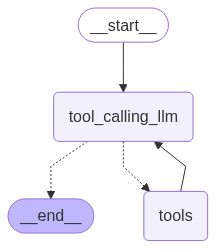

In [17]:
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

def tool_calling_llm(state:State):
    return {"messages": [model_with_tools.invoke(state["messages"])]}

builder = StateGraph(State)
builder.add_node("tool_calling_llm", tool_calling_llm)
builder.add_node("tools", ToolNode(tools))

builder.add_edge(START, "tool_calling_llm")
builder.add_conditional_edges(
    "tool_calling_llm",
    #If the latest message(result) from assistant is a tool call -> tools_condition routes to tools
    #If the latest message(result) from assistant is not a tool call -> tools_condition routes to END
    tools_condition,
)
builder.add_edge("tools", "tool_calling_llm")

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))

In [18]:
messages = graph.invoke({"messages":HumanMessage(content="Provide me the top 10 recent AI news and add 5 plus 6 and multipy by 59")})
for m in messages['messages']:
    m.pretty_print()

================================ Human Message =================================

Provide me the top 10 recent AI news and add 5 plus 6 and multipy by 59
================================== Ai Message ==================================
Tool Calls:
  tavily_search_results_json (gg3q3p808)
 Call ID: gg3q3p808
  Args:
    query: top 10 recent AI news
  add (4tq673fg8)
 Call ID: 4tq673fg8
  Args:
    a: 5
    b: 6
================================= Tool Message =================================
Name: tavily_search_results_json

[{"title": "AI News | June 28–July 4, 2025: Top 10 AI Breakthroughs You Need ...", "url": "https://medium.com/@CherryZhouTech/ai-news-june-28-july-4-2025-top-10-ai-breakthroughs-you-need-to-know-6960d3f67b3a", "content": "By automating narrative and asset generation, Game Worlds dramatically lowers game development barriers.\n\n## 9. OpenAI Denies Robinhood’s “Tokenized Stock” Claims\n\nThe AI firm publicly refuted Robinhood’s EU offering of so-called “OpenAI tokens,”